<a href="https://colab.research.google.com/github/Unholy-Applepie/Bankruptcy-Prediction/blob/main/2_Traditional_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before excecuting the code it is needed to import the data.scv file

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
!pip install catboost
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')



from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest
from sklearn import tree

# Load Data

In [ ]:
#Input data csv
data = pd.read_csv('/data.csv')
print(data.shape)
#Taking first column "?Bankrupt" as the classifications and encoding
classifications = data.iloc[:, 0]
encoder = LabelEncoder()
y = encoder.fit_transform(classifications)
classification_name=np.unique(np.array(['Not Bankrupt', 'Bankrupt'])) # 0 = not bankrupt, 1 = bankrupt

#Taking all other columns as input features and scaling
X = data.iloc[:, 1:]
scaler = StandardScaler()
X=np.array(X)
X=scaler.fit_transform(X)

#Appending data scaled to classifications again (scaled after removing clasification as to not have classification be scaled or have an effect on scaling)
data_scaled=[]
for i in range(X.shape[0]):
    data_scaled.append([X[i],y[i]])

#Shuffling the data
import random
random.shuffle(data_scaled)

# Define the proportion of data for training and testing
train_percentage = 0.8  # 80% for training, 20% for testing
total_samples = len(data_scaled)
train_size = int(train_percentage * total_samples)

# Split the data into training and testing sets
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]



#Splitting train data
X = []
y = []
for features, label in train_data:
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)

#Splitting test data
X_test = []
y_test = []
for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)






(6819, 96)
(5455, 95)
(5455,)
(1364, 95)
(1364,)


<Axes: ylabel='count'>

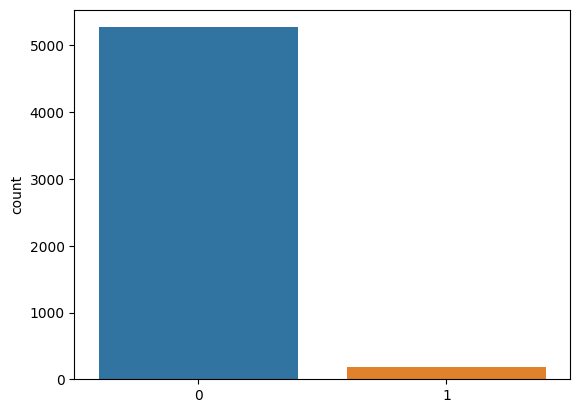

In [ ]:
sns.countplot(x=y)

As we can see our data is really skewed as we got around 5000 non-bankruptcy samples and only hundreds of bankruptcy samples

# **After having loaded and splitted the data we apply Oversampling and UnderSampling Methods**

# OverSampling

We want that the number of sample of bankruptcy to match the number of non-bankruptcy so we apply differents methods of oversampling and undersampling to test which one perform the best

## Oversampling with Smote



<Axes: ylabel='count'>

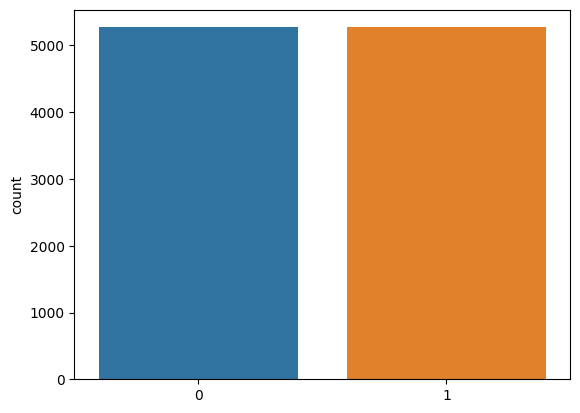

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
#We create the train variable from X and y after oversampling
X_Smote,y_Smote=oversample.fit_resample(X,y)
#We create aswell train variable with only the featires selcted by selectKBest
feature_selection_KBestSmote=SelectKBest(f_classif,k=13).fit(X_Smote,y_Smote)
X_SmoteSF = feature_selection_KBestSmote.transform(X_Smote)
sns.countplot(x=y_Smote)

## Oversampling with random Oversampling

<Axes: ylabel='count'>

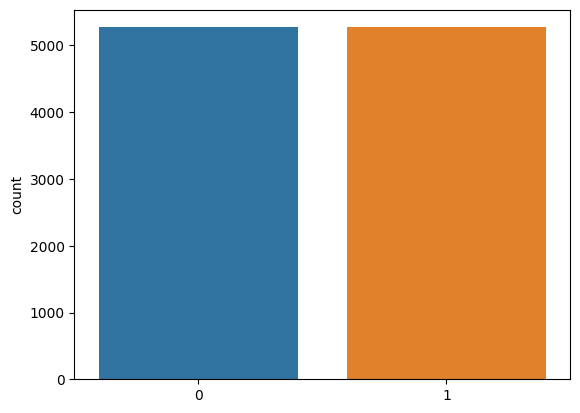

In [ ]:
over_sampler = RandomOverSampler(random_state=42)
X_randomOver, y_randomOver = over_sampler.fit_resample(X , y)
sns.countplot(x=y_randomOver)

## Oversampling with Adasyn

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# UnderSampling

## Undersampling with random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_randomUnder, y_randomUnder = rus.fit_resample(X, y)

<Axes: ylabel='count'>

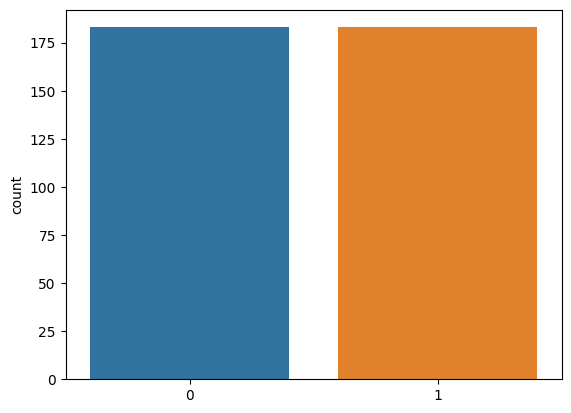

In [ ]:
sns.countplot(x=y_randomUnder)

# **We have now created all the variable for each sampling methods. We apply now all our basic machine learing methods to all those variables**

# Test models functions

We create two function to test our models on our test_data. One for testing with our initial features and another one with only our selected features

In [ ]:
def test_model(model):
  #Tests
  predictions = model.predict(X_test)
  predicted_labels = (model.predict(X_test) > 0.5).astype(int).flatten()

  # Calculate the confusion matrix
  confusion = confusion_matrix(y_test, predicted_labels)

  # Extract the TP, TN, FP, and FN values
  TP = confusion[1, 1]  # True Positives
  TN = confusion[0, 0]  # True Negatives
  FP = confusion[0, 1]  # False Positives
  FN = confusion[1, 0]  # False Negatives

  print("-"*30)
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
              xticklabels=["Predicted 0", "Predicted 1"],
              yticklabels=["Actual 0", "Actual 1"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print("-"*30)
  # Calculate the percentages
  percentage_positive_predicted_correctly = (TP / (TP + FN)) * 100
  percentage_negative_predicted_correctly = (TN / (TN + FP)) * 100

  # Print or use these percentages as needed
  print(f"Percentage of positive (1) predicted correctly: {TP} / {TP+FN} = {percentage_positive_predicted_correctly:.2f}%")
  print(f"Percentage of negative (0) predicted correctly: {TN} / {TN+FP} = {percentage_negative_predicted_correctly:.2f}%")
  v1 = TP/(TP+FN)
  v2 = TN/(TN+FP)
  print("Classification Report:\n", classification_report(y_test, predicted_labels))
  # returning weighted average accuracy
  return (v1+v2)/2

In [ ]:
def test_model_selected_features(model, feature_selection_KBest):
  X_test_sf = feature_selection_KBest.transform(X_test)
  #Tests
  predictions = model.predict(X_test_sf)

  predicted_labels = (model.predict(X_test_sf) > 0.5).astype(int).flatten()

  # Calculate the confusion matrix
  confusion = confusion_matrix(y_test, predicted_labels)

  # Extract the TP, TN, FP, and FN values
  TP = confusion[1, 1]  # True Positives
  TN = confusion[0, 0]  # True Negatives
  FP = confusion[0, 1]  # False Positives
  FN = confusion[1, 0]  # False Negatives

  print("-"*30)
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
              xticklabels=["Predicted 0", "Predicted 1"],
              yticklabels=["Actual 0", "Actual 1"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print("-"*30)
  # Calculate the percentages
  percentage_positive_predicted_correctly = (TP / (TP + FN)) * 100
  percentage_negative_predicted_correctly = (TN / (TN + FP)) * 100

  # Print or use these percentages as needed
  print(f"Percentage of positive (1) predicted correctly: {TP} / {TP+FN} = {percentage_positive_predicted_correctly:.2f}%")
  print(f"Percentage of negative (0) predicted correctly: {TN} / {TN+FP} = {percentage_negative_predicted_correctly:.2f}%")
  v1 = TP/(TP+FN)
  v2 = TN/(TN+FP)
  print("Classification Report:\n", classification_report(y_test, predicted_labels))
  # returning weighted average accuracy
  return (v1+v2)/2

# Smote Models applications

## Logistic Regression with Smote




------------------------------


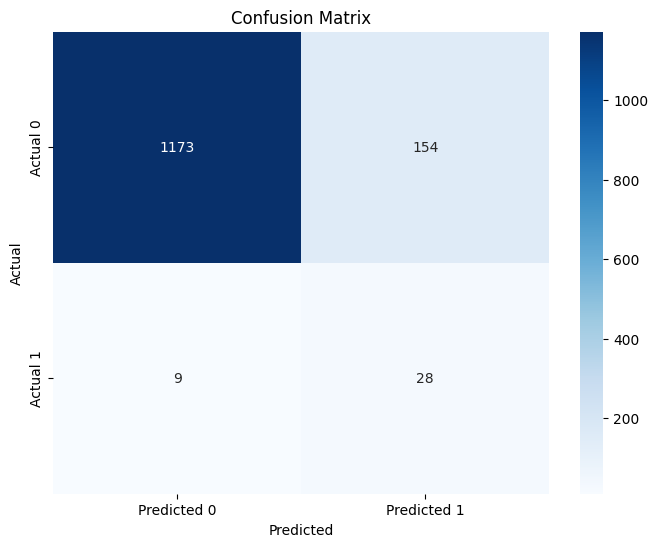

------------------------------
Percentage of positive (1) predicted correctly: 28 / 37 = 75.68%
Percentage of negative (0) predicted correctly: 1173 / 1327 = 88.39%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.94      1327
           1       0.15      0.76      0.26        37

    accuracy                           0.88      1364
   macro avg       0.57      0.82      0.60      1364
weighted avg       0.97      0.88      0.92      1364



0.8203527566752887

In [ ]:
#We start by creating our model and then we train it on our train data oversampled by Smote
log_reg=LogisticRegression()
log_reg.fit(X_Smote,y_Smote)
y_pred_Smote=log_reg.predict(X_test)
test_model(log_reg)

## RandomForest with Smote

In [ ]:
ClassifierRf=RandomForestClassifier(random_state=42)
ClassifierRf.fit(X_Smote,y_Smote)

RandomForestClassifier(random_state=42)

------------------------------


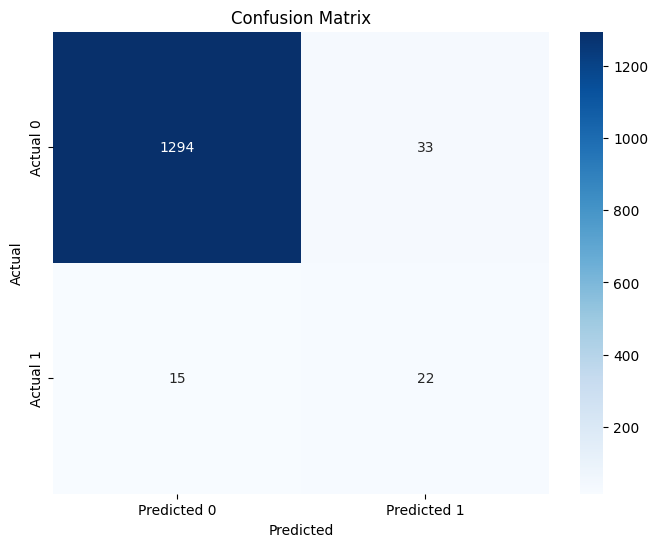

------------------------------
Percentage of positive (1) predicted correctly: 22 / 37 = 59.46%
Percentage of negative (0) predicted correctly: 1294 / 1327 = 97.51%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1327
           1       0.40      0.59      0.48        37

    accuracy                           0.96      1364
   macro avg       0.69      0.78      0.73      1364
weighted avg       0.97      0.96      0.97      1364



0.7848632355037781

In [ ]:
y_pred_RandomForest = ClassifierRf.predict(X_test)
test_model(ClassifierRf)

## CatBoost with Smote

In [ ]:
ClassifierCb = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
ClassifierCb.fit(X_Smote, y_Smote
)

0:	learn: 0.5896648	total: 171ms	remaining: 684ms
1:	learn: 0.4954880	total: 287ms	remaining: 430ms
2:	learn: 0.4335389	total: 413ms	remaining: 275ms
3:	learn: 0.3887262	total: 528ms	remaining: 132ms
4:	learn: 0.3577694	total: 670ms	remaining: 0us


------------------------------


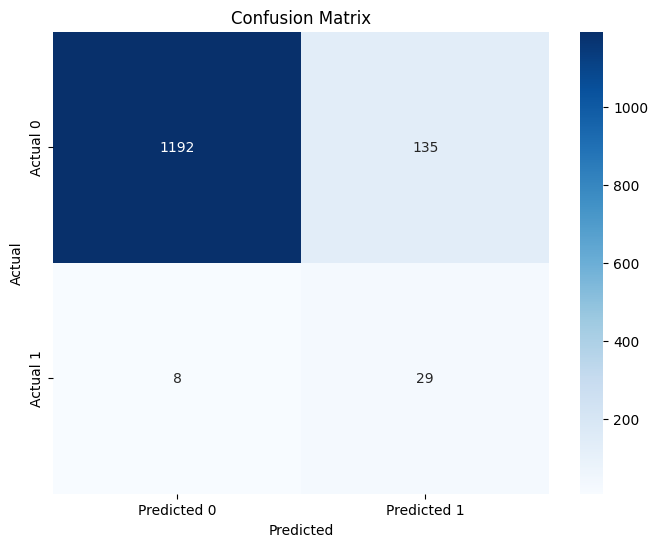

------------------------------
Percentage of positive (1) predicted correctly: 29 / 37 = 78.38%
Percentage of negative (0) predicted correctly: 1192 / 1327 = 89.83%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      1327
           1       0.18      0.78      0.29        37

    accuracy                           0.90      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.97      0.90      0.93      1364



0.8410252754638587

In [ ]:
y_pred_catboost = ClassifierCb.predict(X_test)
test_model(ClassifierCb)

## Decision Tree with Smote

------------------------------


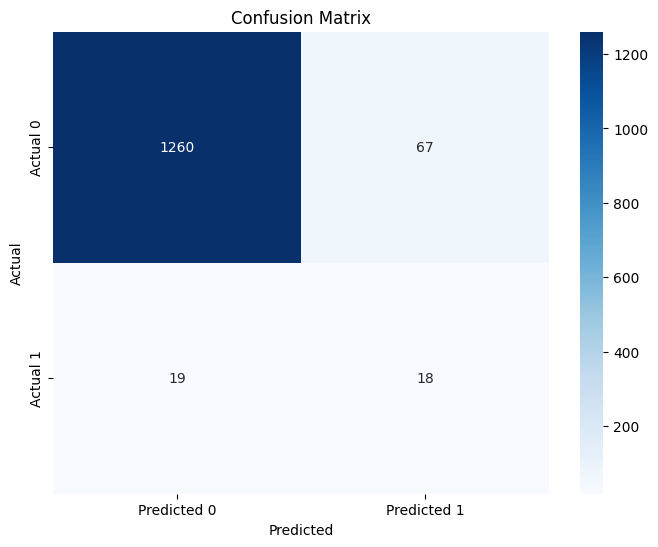

------------------------------
Percentage of positive (1) predicted correctly: 18 / 37 = 48.65%
Percentage of negative (0) predicted correctly: 1260 / 1327 = 94.95%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1327
           1       0.21      0.49      0.30        37

    accuracy                           0.94      1364
   macro avg       0.60      0.72      0.63      1364
weighted avg       0.96      0.94      0.95      1364



0.717998329904886

In [ ]:
clf3=tree.DecisionTreeClassifier()
clf3.fit(X_Smote,y_Smote)
y_pred=clf3.predict(X_test)
test_model(clf3)

## SVM with Smote

------------------------------


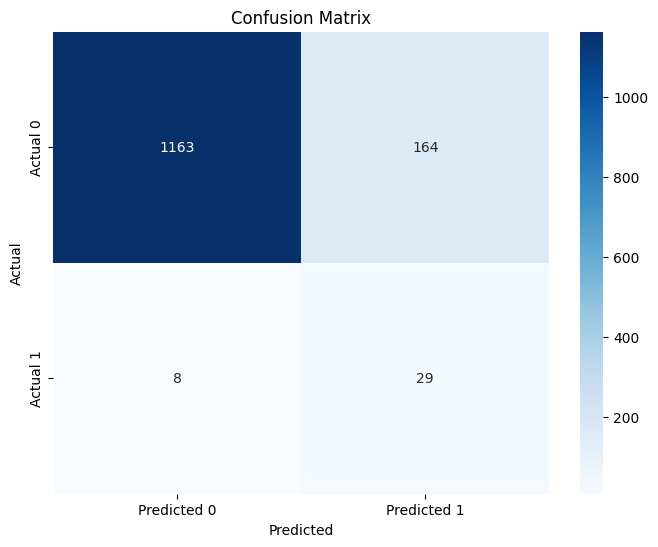

------------------------------
Percentage of positive (1) predicted correctly: 29 / 37 = 78.38%
Percentage of negative (0) predicted correctly: 1163 / 1327 = 87.64%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      1327
           1       0.15      0.78      0.25        37

    accuracy                           0.87      1364
   macro avg       0.57      0.83      0.59      1364
weighted avg       0.97      0.87      0.91      1364



0.8300983726756146

In [ ]:
svm_classifier=SVC(kernel='linear')
svm_classifier.fit(X_Smote,y_Smote)
y_pred=svm_classifier.predict(X_test)
test_model(svm_classifier)

# Random Oversampling Models Applications

## Logistic Regression with Random Oversampling


------------------------------


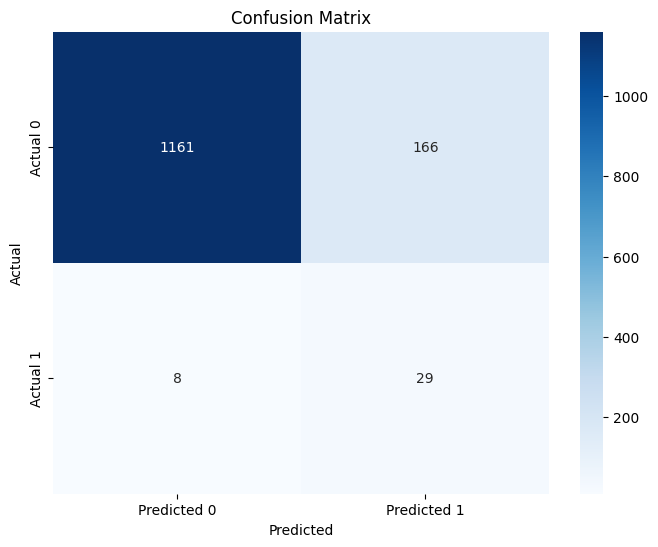

------------------------------
Percentage of positive (1) predicted correctly: 29 / 37 = 78.38%
Percentage of negative (0) predicted correctly: 1161 / 1327 = 87.49%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1327
           1       0.15      0.78      0.25        37

    accuracy                           0.87      1364
   macro avg       0.57      0.83      0.59      1364
weighted avg       0.97      0.87      0.91      1364



0.829344793172977

In [ ]:
log_reg=LogisticRegression()
log_reg.fit(X_randomOver,y_randomOver)

y_pred_randomOver=log_reg.predict(X_test)
test_model(log_reg)

## Random forest with Random Oversampling

------------------------------


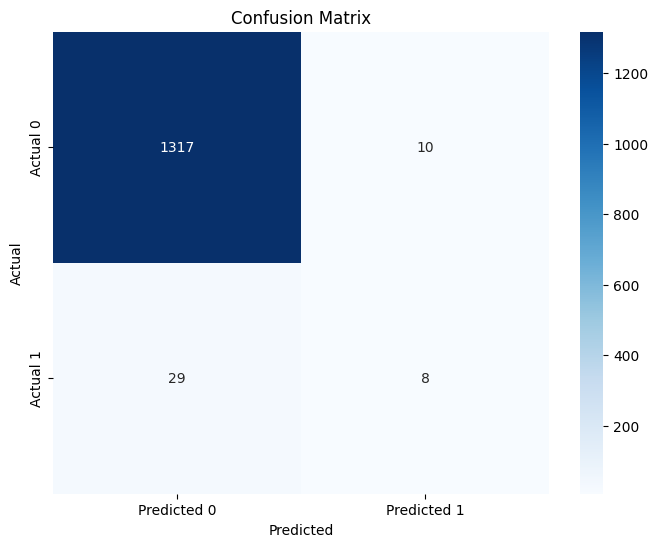

------------------------------
Percentage of positive (1) predicted correctly: 8 / 37 = 21.62%
Percentage of negative (0) predicted correctly: 1317 / 1327 = 99.25%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1327
           1       0.44      0.22      0.29        37

    accuracy                           0.97      1364
   macro avg       0.71      0.60      0.64      1364
weighted avg       0.96      0.97      0.97      1364



0.6043402105949205

In [ ]:
ClassifierRf=RandomForestClassifier(random_state=42)
ClassifierRf.fit(X_randomOver,y_randomOver)
y_pred_randomOver = ClassifierRf.predict(X_test)
test_model(ClassifierRf)

## CatBoost with Random Oversampling

0:	learn: 0.5951939	total: 32.5ms	remaining: 130ms
1:	learn: 0.5069810	total: 60.4ms	remaining: 90.5ms
2:	learn: 0.4486885	total: 85.2ms	remaining: 56.8ms
3:	learn: 0.4007843	total: 110ms	remaining: 27.5ms
4:	learn: 0.3622520	total: 136ms	remaining: 0us
------------------------------


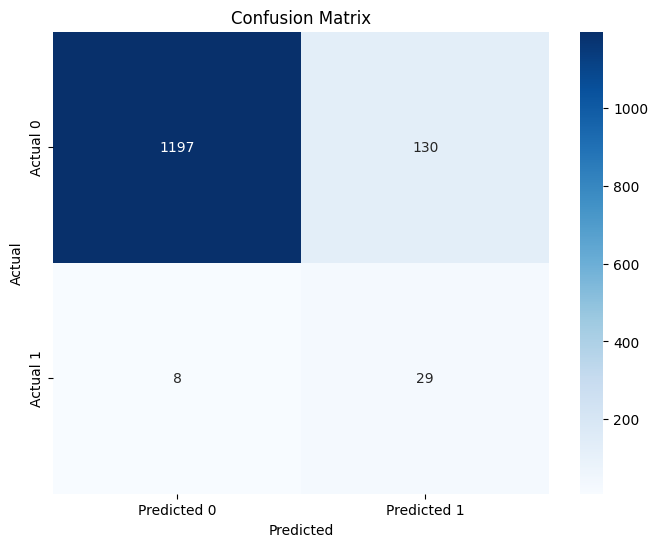

------------------------------
Percentage of positive (1) predicted correctly: 29 / 37 = 78.38%
Percentage of negative (0) predicted correctly: 1197 / 1327 = 90.20%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95      1327
           1       0.18      0.78      0.30        37

    accuracy                           0.90      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.97      0.90      0.93      1364



0.8429092242204526

In [ ]:
ClassifierCbRandomOver = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
ClassifierCbRandomOver.fit(X_randomOver, y_randomOver)
y_pred_catboostrandomOver = ClassifierCbRandomOver.predict(X_test)
test_model(ClassifierCbRandomOver)

## Decision Tree with Random Oversampling

------------------------------


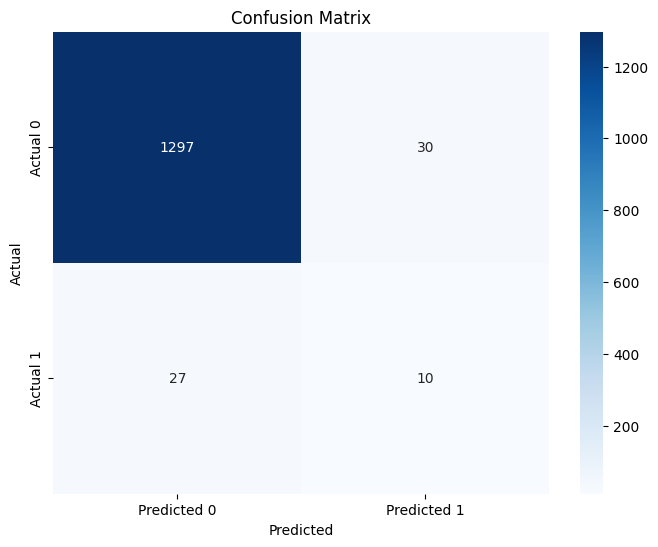

------------------------------
Percentage of positive (1) predicted correctly: 10 / 37 = 27.03%
Percentage of negative (0) predicted correctly: 1297 / 1327 = 97.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1327
           1       0.25      0.27      0.26        37

    accuracy                           0.96      1364
   macro avg       0.61      0.62      0.62      1364
weighted avg       0.96      0.96      0.96      1364



0.6238314425955722

In [ ]:
clf2=tree.DecisionTreeClassifier()
clf2.fit(X_randomOver,y_randomOver)
y_pred=clf2.predict(X_test)
test_model(clf2)

## SVM with Random Oversampling

------------------------------


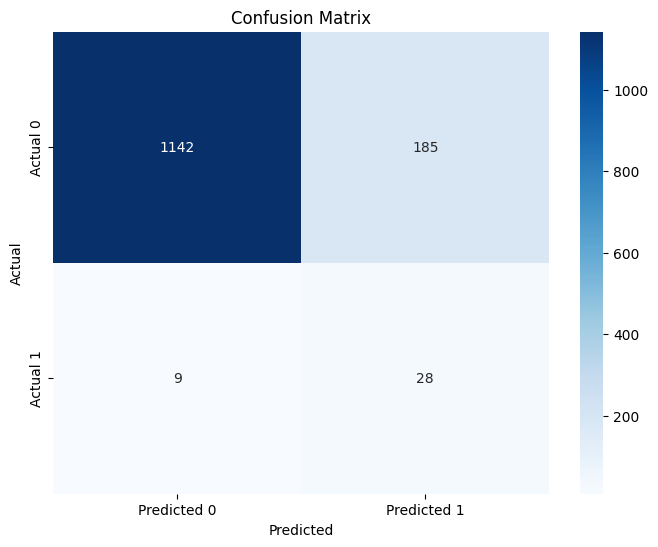

------------------------------
Percentage of positive (1) predicted correctly: 28 / 37 = 75.68%
Percentage of negative (0) predicted correctly: 1142 / 1327 = 86.06%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1327
           1       0.13      0.76      0.22        37

    accuracy                           0.86      1364
   macro avg       0.56      0.81      0.57      1364
weighted avg       0.97      0.86      0.90      1364



0.808672274384407

In [ ]:
svm_classifier2=SVC(kernel='linear')
svm_classifier2.fit(X_randomOver,y_randomOver)
y_pred=svm_classifier2.predict(X_test)
test_model(svm_classifier2)

# Adasyn Models Application

## Linear Regression with Adasyn

------------------------------


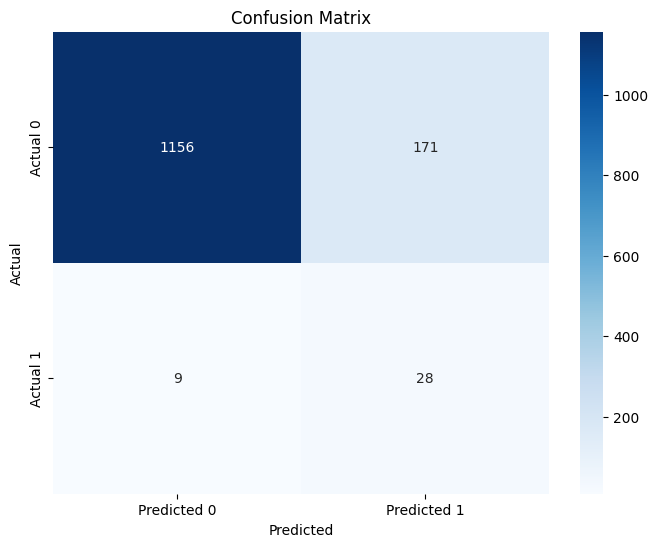

------------------------------
Percentage of positive (1) predicted correctly: 28 / 37 = 75.68%
Percentage of negative (0) predicted correctly: 1156 / 1327 = 87.11%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1327
           1       0.14      0.76      0.24        37

    accuracy                           0.87      1364
   macro avg       0.57      0.81      0.58      1364
weighted avg       0.97      0.87      0.91      1364



0.8139473309028697

In [ ]:
log_reg=LogisticRegression()
log_reg.fit(X_adasyn,y_adasyn)

y_pred_Adasyn=log_reg.predict(X_test)
test_model(log_reg)

## Random Forest with Adasyn

------------------------------


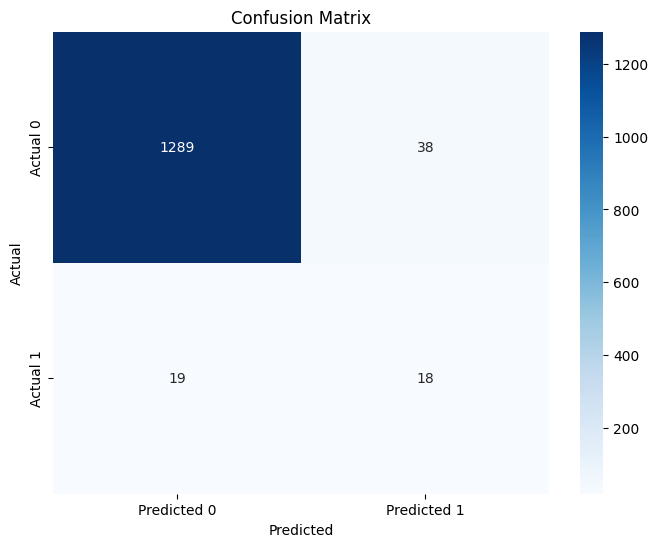

------------------------------
Percentage of positive (1) predicted correctly: 18 / 37 = 48.65%
Percentage of negative (0) predicted correctly: 1289 / 1327 = 97.14%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1327
           1       0.32      0.49      0.39        37

    accuracy                           0.96      1364
   macro avg       0.65      0.73      0.68      1364
weighted avg       0.97      0.96      0.96      1364



0.7289252326931301

In [ ]:
ClassifierAdasyn =RandomForestClassifier(random_state=42)
ClassifierAdasyn.fit(X_adasyn,y_adasyn)
y_pred_Adasyn = ClassifierAdasyn.predict(X_test)
test_model(ClassifierAdasyn)

## Catboost with Adasyn

0:	learn: 0.5862757	total: 33.9ms	remaining: 135ms
1:	learn: 0.5120180	total: 60.9ms	remaining: 91.3ms
2:	learn: 0.4573153	total: 87.1ms	remaining: 58.1ms
3:	learn: 0.4116612	total: 113ms	remaining: 28.4ms
4:	learn: 0.3764649	total: 140ms	remaining: 0us
------------------------------


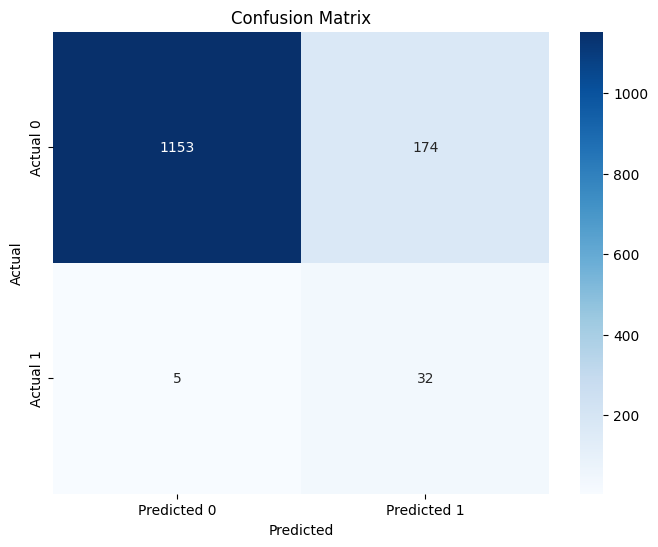

------------------------------
Percentage of positive (1) predicted correctly: 32 / 37 = 86.49%
Percentage of negative (0) predicted correctly: 1153 / 1327 = 86.89%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1327
           1       0.16      0.86      0.26        37

    accuracy                           0.87      1364
   macro avg       0.58      0.87      0.60      1364
weighted avg       0.97      0.87      0.91      1364



0.8668710157029675

In [ ]:
ClassifierCbRandomOver = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
ClassifierCbRandomOver.fit(X_adasyn, y_adasyn)
y_pred_catboostrandomOver = ClassifierCbRandomOver.predict(X_test)
test_model(ClassifierCbRandomOver)

## Decision tree with Adasyn

------------------------------


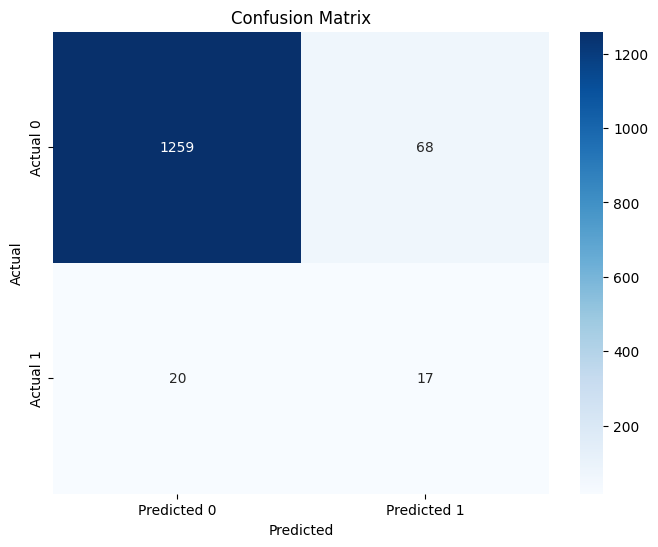

------------------------------
Percentage of positive (1) predicted correctly: 17 / 37 = 45.95%
Percentage of negative (0) predicted correctly: 1259 / 1327 = 94.88%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      1327
           1       0.20      0.46      0.28        37

    accuracy                           0.94      1364
   macro avg       0.59      0.70      0.62      1364
weighted avg       0.96      0.94      0.95      1364



0.7041080266400538

In [ ]:
clf4=tree.DecisionTreeClassifier()
clf4.fit(X_adasyn,y_adasyn)
y_pred=clf4.predict(X_test)
test_model(clf4)

## SVM with Adasyn

------------------------------


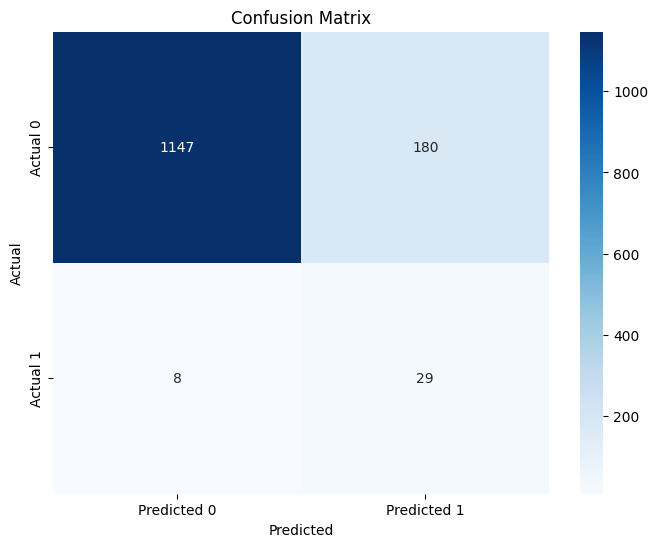

------------------------------
Percentage of positive (1) predicted correctly: 29 / 37 = 78.38%
Percentage of negative (0) predicted correctly: 1147 / 1327 = 86.44%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1327
           1       0.14      0.78      0.24        37

    accuracy                           0.86      1364
   macro avg       0.57      0.82      0.58      1364
weighted avg       0.97      0.86      0.91      1364



0.8240697366545143

In [ ]:
svm_classifier3=SVC(kernel='linear')
svm_classifier3.fit(X_adasyn,y_adasyn)
y_pred=svm_classifier3.predict(X_test)
test_model(svm_classifier3)

# Random Undersampling Models Applications

## Logistic Regression with random undersampling

------------------------------


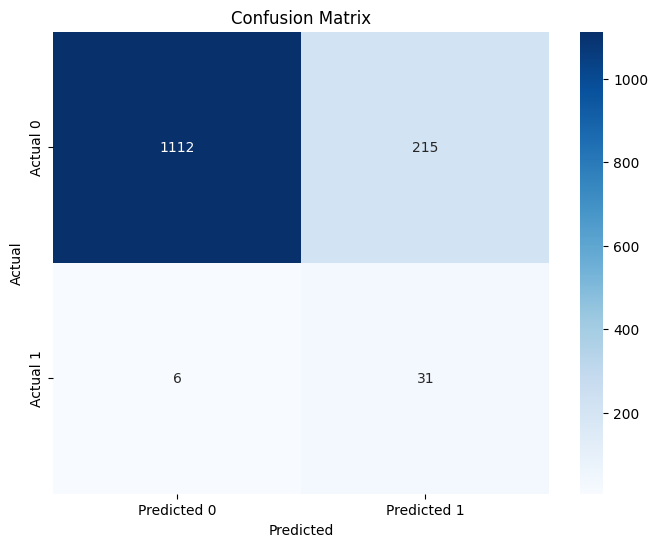

------------------------------
Percentage of positive (1) predicted correctly: 31 / 37 = 83.78%
Percentage of negative (0) predicted correctly: 1112 / 1327 = 83.80%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1327
           1       0.13      0.84      0.22        37

    accuracy                           0.84      1364
   macro avg       0.56      0.84      0.56      1364
weighted avg       0.97      0.84      0.89      1364



0.8379091223853846

In [ ]:
log_reg_randomUnder=LogisticRegression()
log_reg_randomUnder.fit(X_randomUnder,y_randomUnder)
y_pred_randomUnder=log_reg_randomUnder.predict(X_test)
test_model(log_reg_randomUnder)

## Random Forest With Under Sampling

------------------------------


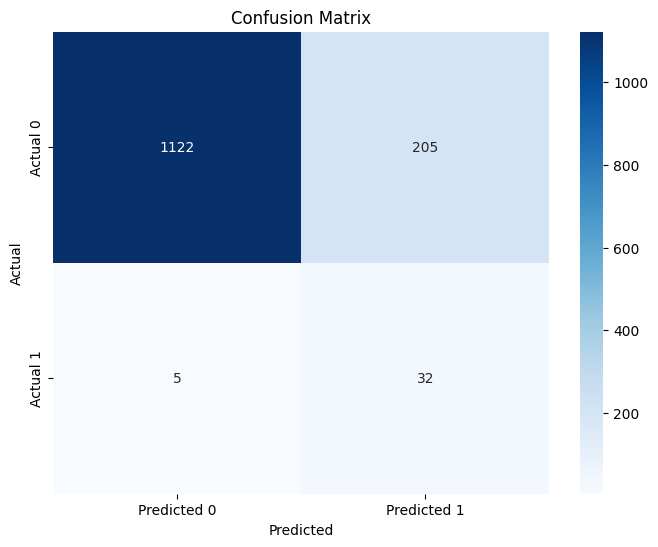

------------------------------
Percentage of positive (1) predicted correctly: 32 / 37 = 86.49%
Percentage of negative (0) predicted correctly: 1122 / 1327 = 84.55%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.91      1327
           1       0.14      0.86      0.23        37

    accuracy                           0.85      1364
   macro avg       0.57      0.86      0.57      1364
weighted avg       0.97      0.85      0.90      1364



0.8551905334120857

In [ ]:
ClassifierRfUnder=RandomForestClassifier(random_state=42)
ClassifierRfUnder.fit(X_randomUnder,y_randomUnder)
y_pred_randomUnder = ClassifierRfUnder.predict(X_test)
test_model(ClassifierRfUnder)

## Cat Boost with Under Sampling

0:	learn: 0.6019619	total: 30.8ms	remaining: 123ms
1:	learn: 0.5336141	total: 50.6ms	remaining: 75.9ms
2:	learn: 0.4734689	total: 68.6ms	remaining: 45.7ms
3:	learn: 0.4218951	total: 93.6ms	remaining: 23.4ms
4:	learn: 0.3862153	total: 114ms	remaining: 0us
------------------------------


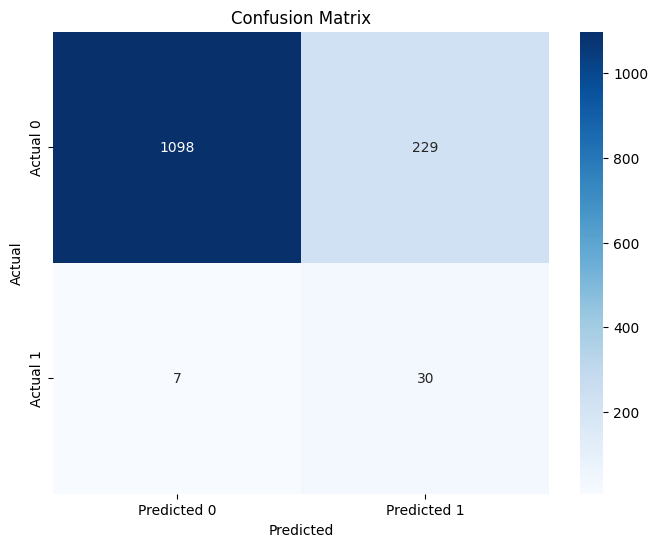

------------------------------
Percentage of positive (1) predicted correctly: 30 / 37 = 81.08%
Percentage of negative (0) predicted correctly: 1098 / 1327 = 82.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1327
           1       0.12      0.81      0.20        37

    accuracy                           0.83      1364
   macro avg       0.55      0.82      0.55      1364
weighted avg       0.97      0.83      0.88      1364



0.8191205523534084

In [ ]:
ClassifierCbRandomUnder = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
ClassifierCbRandomUnder.fit(X_randomUnder, y_randomUnder)
y_pred_catboostrandomUnder = ClassifierCbRandomUnder.predict(X_test)
test_model(ClassifierCbRandomUnder)

## Decision Tree with Undersampling

------------------------------


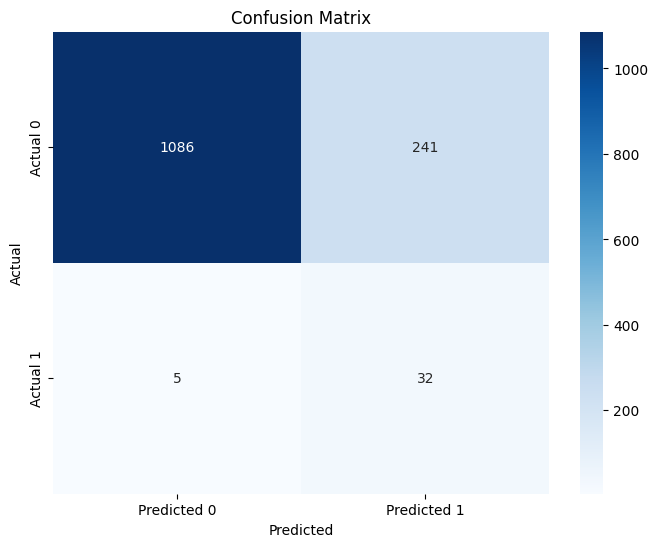

------------------------------
Percentage of positive (1) predicted correctly: 32 / 37 = 86.49%
Percentage of negative (0) predicted correctly: 1086 / 1327 = 81.84%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90      1327
           1       0.12      0.86      0.21        37

    accuracy                           0.82      1364
   macro avg       0.56      0.84      0.55      1364
weighted avg       0.97      0.82      0.88      1364



0.8416261023646103

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_randomUnder,y_randomUnder)
y_pred=clf.predict(X_test)
test_model(clf)

## SVC with Undersampling

------------------------------


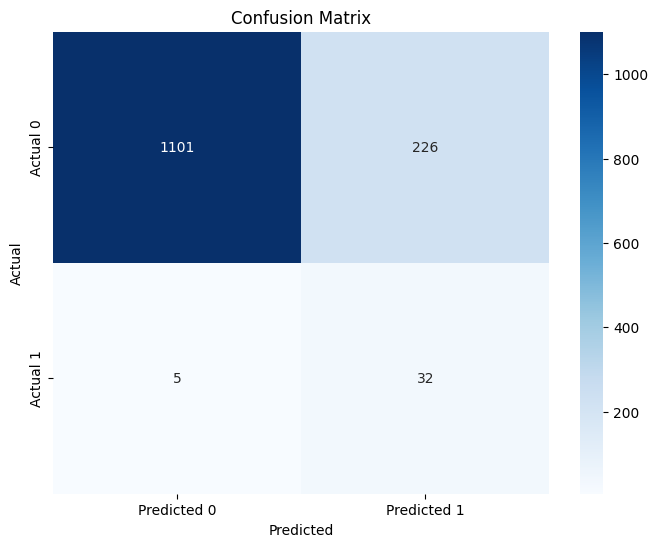

------------------------------
Percentage of positive (1) predicted correctly: 32 / 37 = 86.49%
Percentage of negative (0) predicted correctly: 1101 / 1327 = 82.97%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      1327
           1       0.12      0.86      0.22        37

    accuracy                           0.83      1364
   macro avg       0.56      0.85      0.56      1364
weighted avg       0.97      0.83      0.89      1364



0.8472779486343918

In [ ]:
svm_classifier4=SVC(kernel='linear')
svm_classifier4.fit(X_randomUnder,y_randomUnder)
y_pred=svm_classifier4.predict(X_test)
test_model(svm_classifier4)

# Application of the models with smote after KBest Features selection

We have seen that smote seem to perform the best for traditional machine learing methods. We want to test the utility of KBest feature selection so we apply KBest with Smote.

## Logistic Regression

------------------------------


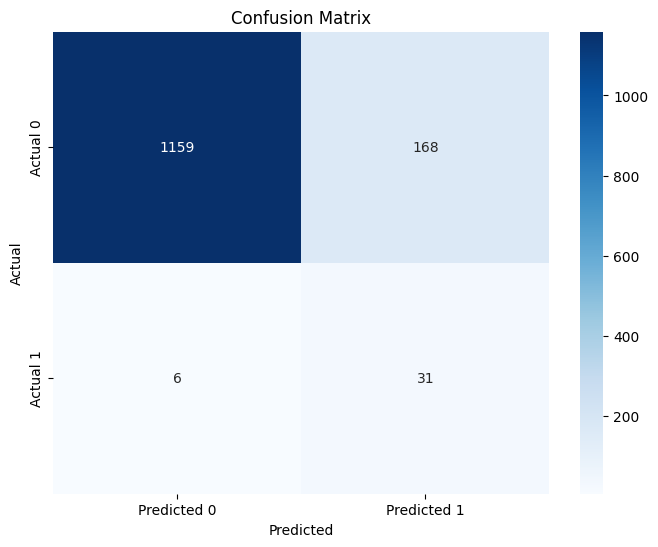

------------------------------
Percentage of positive (1) predicted correctly: 31 / 37 = 83.78%
Percentage of negative (0) predicted correctly: 1159 / 1327 = 87.34%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1327
           1       0.16      0.84      0.26        37

    accuracy                           0.87      1364
   macro avg       0.58      0.86      0.60      1364
weighted avg       0.97      0.87      0.91      1364



0.8556182406973665

In [ ]:
#As we said before we apply the feature selection with smote to see the impact of choosing the features
log_reg_Smote_SF =LogisticRegression()
log_reg_Smote_SF.fit(X_SmoteSF,y_Smote)
X_test_sf = feature_selection_KBestSmote.transform(X_test)
y_pred_Smote_sf = log_reg_Smote_SF.predict(X_test_sf)
test_model_selected_features(log_reg_Smote_SF,feature_selection_KBestSmote)

## Random Forest

------------------------------


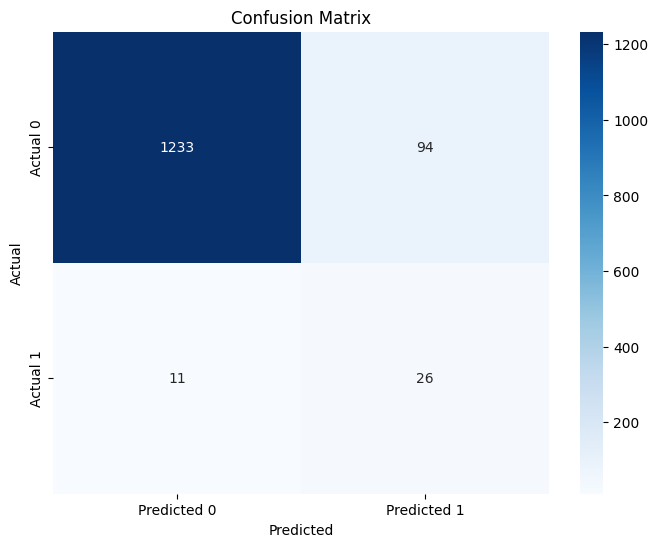

------------------------------
Percentage of positive (1) predicted correctly: 26 / 37 = 70.27%
Percentage of negative (0) predicted correctly: 1233 / 1327 = 92.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1327
           1       0.22      0.70      0.33        37

    accuracy                           0.92      1364
   macro avg       0.60      0.82      0.65      1364
weighted avg       0.97      0.92      0.94      1364



0.8159331147273876

In [ ]:
Classifier_Forest_Smote_SF =RandomForestClassifier(random_state=42)
Classifier_Forest_Smote_SF.fit(X_SmoteSF,y_Smote)
X_test_sf = feature_selection_KBestSmote.transform(X_test)
y_pred_Smote_sf = Classifier_Forest_Smote_SF.predict(X_test_sf)
test_model_selected_features(Classifier_Forest_Smote_SF,feature_selection_KBestSmote)

## CatBoost

0:	learn: 0.6357325	total: 5.96ms	remaining: 23.8ms
1:	learn: 0.5904471	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.5508439	total: 16.3ms	remaining: 10.8ms
3:	learn: 0.5179994	total: 21.5ms	remaining: 5.37ms
4:	learn: 0.4894755	total: 26.6ms	remaining: 0us
------------------------------


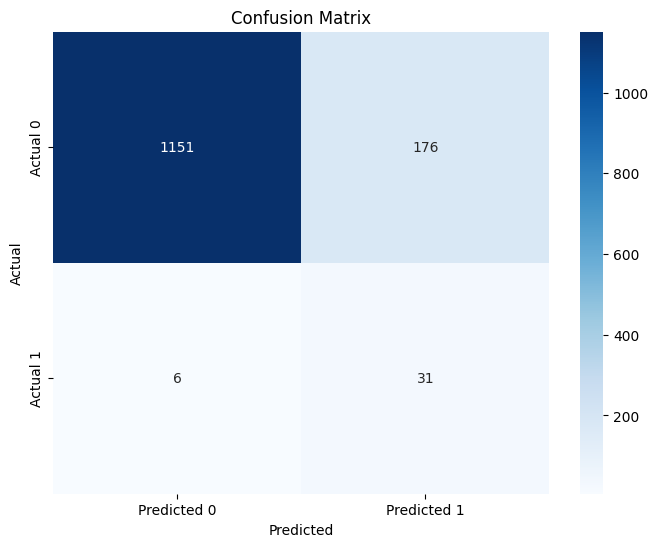

------------------------------
Percentage of positive (1) predicted correctly: 31 / 37 = 83.78%
Percentage of negative (0) predicted correctly: 1151 / 1327 = 86.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1327
           1       0.15      0.84      0.25        37

    accuracy                           0.87      1364
   macro avg       0.57      0.85      0.59      1364
weighted avg       0.97      0.87      0.91      1364



0.8526039226868165

In [ ]:
ClassifierCb_SF = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
ClassifierCb_SF.fit(X_SmoteSF, y_Smote
)

X_test_sf = feature_selection_KBestSmote.transform(X_test)
y_pred_Smote_sf = ClassifierCb_SF.predict(X_test_sf)
test_model_selected_features(ClassifierCb_SF,feature_selection_KBestSmote)

## Decision Tree

------------------------------


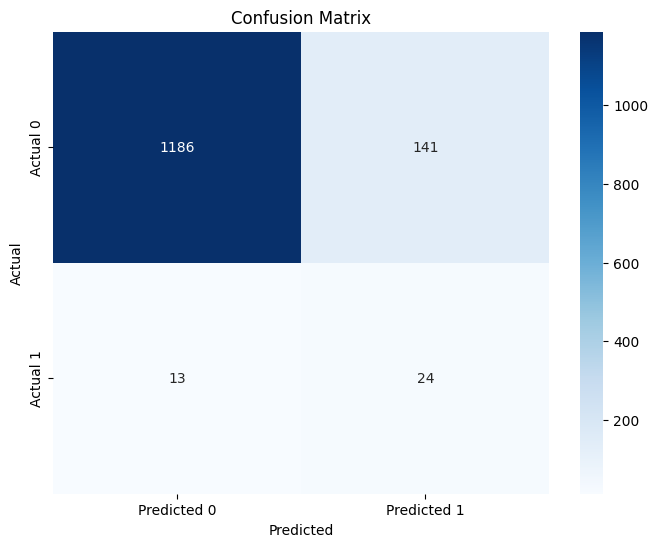

------------------------------
Percentage of positive (1) predicted correctly: 24 / 37 = 64.86%
Percentage of negative (0) predicted correctly: 1186 / 1327 = 89.37%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1327
           1       0.15      0.65      0.24        37

    accuracy                           0.89      1364
   macro avg       0.57      0.77      0.59      1364
weighted avg       0.97      0.89      0.92      1364



0.7711969693883787

In [ ]:
Classifier_Tree_Smote_SF =tree.DecisionTreeClassifier()
Classifier_Tree_Smote_SF.fit(X_SmoteSF,y_Smote)
X_test_sf = feature_selection_KBestSmote.transform(X_test)
y_pred_Smote_sf = Classifier_Tree_Smote_SF.predict(X_test_sf)
test_model_selected_features(Classifier_Tree_Smote_SF,feature_selection_KBestSmote)

## SVM

------------------------------


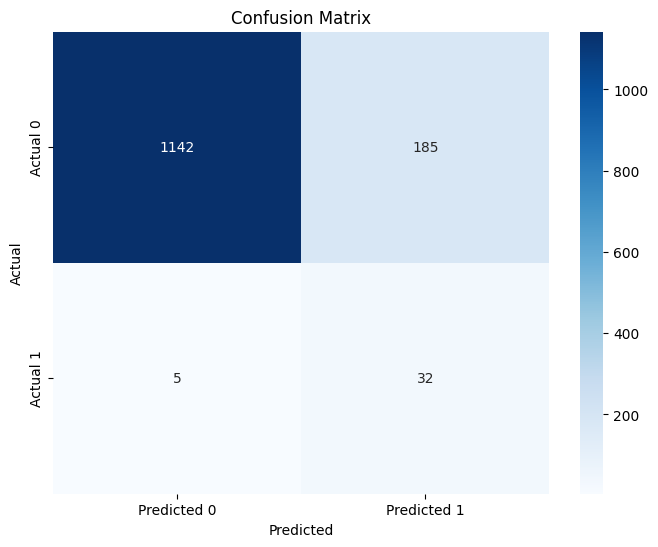

------------------------------
Percentage of positive (1) predicted correctly: 32 / 37 = 86.49%
Percentage of negative (0) predicted correctly: 1142 / 1327 = 86.06%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92      1327
           1       0.15      0.86      0.25        37

    accuracy                           0.86      1364
   macro avg       0.57      0.86      0.59      1364
weighted avg       0.97      0.86      0.90      1364



0.8627263284384611

In [ ]:
Classifier_SVM_Smote_SF =SVC(kernel='linear')
Classifier_SVM_Smote_SF.fit(X_SmoteSF,y_Smote)
X_test_sf = feature_selection_KBestSmote.transform(X_test)
y_pred_Smote_sf = Classifier_SVM_Smote_SF.predict(X_test_sf)
test_model_selected_features(Classifier_SVM_Smote_SF,feature_selection_KBestSmote)